<h1>Generating Data Based on:</h1>
<ol>
<li>AR3<ol>
    <li>Phi: autoregression weight</li>
    <li>Sigma: variance of noice</li>
    </ol>
    <br>
    
<li>ARMA(3,3)<ol>
    <li>Phi: autoregression weight</li>
    <li>Theta: moving average weight</li>
    <li>Sigma: variance of noise</li>
    <li>obs_cov</li>
    <li>state_cov</li>
    </ol>
    <br>
    
    
<li>TVARX<ol>
    <li>obs_cov</li>
    <li>state_cov</li>
    </ol>
    <br>
    </ol>



In [1]:
import numpy as np
from scipy.signal import lfilter
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)
import sympy as sym
%matplotlib inline


<li>AR2<ol>
    <li>Phi: autoregression weight</li>
    <li>Sigma: variance of noice</li>
    </ol>


\begin{equation*}
{\phi}(L)y_{t} = \epsilon_t \\
y_{t} = {\phi_1}y_{t-1} + {\phi_2}y_{t-2} +  \epsilon_t \\
(1-\sum_{1=1}^2 a_iL^i)y_t = \epsilon_t \\
\epsilon_t \sim N(0,\sigma^2)\\
\phi_1 = 0.5 \\
\phi_2 = -0.2 \\
\sigma^2 = 1
\end{equation*}

State Space Representation: 

\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 
\end{vmatrix} \alpha_t \\
\alpha_{t+1} = \begin{vmatrix}
\phi_1 & \phi_2  \\
1 & 0  
\end{vmatrix} \alpha_t + \begin{vmatrix}
1 \\
0 
\end{vmatrix} \eta_t \\
\eta_t = \epsilon_{t+1} \sim N(0,\sigma^2)
\end{equation*}

In [21]:
# True model parameters
nobs = int(1e3)
true_phi = np.r_[0.5, -0.2]
true_sigma = 1**0.5

# Simulate a time series
np.random.seed(1234)
disturbances = np.random.normal(0, true_sigma, size=(nobs,))
endog = lfilter([1], np.r_[1, -true_phi], disturbances)

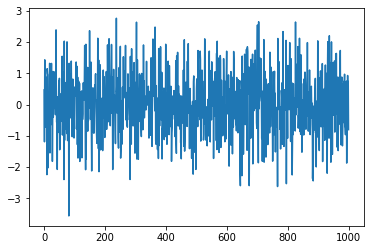

In [22]:
plt.plot(disturbances)

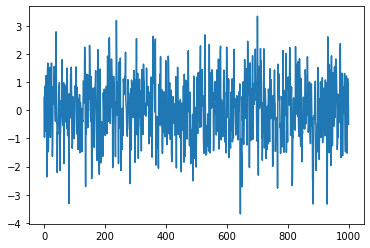

In [23]:
plt.plot(endog)

In [24]:
# We could fit an AR(2) model, described above
mod_ar2 = sm.tsa.SARIMAX(endog, order=(2,0,0))
# Note that mod_ar2 is an instance of the SARIMAX class

# Fit the model via maximum likelihood
res_ar2 = mod_ar2.fit()
# Note that res_ar2 is an instance of the SARIMAXResults class

# Show the summary of results
print(res_ar2.summary())



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38944D+00    |proj g|=  7.03247D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      6      1     0     0   3.674D-06   1.389D+00
  F =   1.3894371899024731     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(2, 0, 0

 This problem is unconstrained.


<h1>Custom model: AR2</h1>

In [25]:
# Construct the model
class AR2(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(AR2, self).__init__(endog, k_states=2, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0]
        self['transition'] = [[0, 0],
                                  [1, 0]]
        self['selection', 0, 0] = 1

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(AR2, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:2]
        self['state_cov', 0, 0] = params[2]

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,1]  # these are very simple

# Create and fit the model
mod = AR2(endog)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48642D+00    |proj g|=  4.13724D-01

At iterate    5    f=  1.38944D+00    |proj g|=  2.39503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   5.589D-07   1.389D+00
  F =   1.3894371898898661     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observati

 This problem is unconstrained.


<li>AR3<ol>
    <li>Phi: autoregression weight</li>
    <li>Sigma: variance of noice</li>
    </ol>


\begin{equation*}
{\phi}(L)y_{t} = \epsilon_t \\
y_{t} = {\phi_1}y_{t-1} + {\phi_2}y_{t-2} + {\phi_3}y_{t-3} +\epsilon_t \\
(1-\sum_{1=1}^3 a_iL^i)y_t = \epsilon_t \\
\epsilon_t \sim N(0,\sigma^2)\\
\phi_1 = 0.5 \\
\phi_2 = -0.2 \\
\phi_3 = 0.3 \\
\sigma^2 = 1
\end{equation*}

State Space Representation: 

\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 & 0
\end{vmatrix} \alpha_t \\
\alpha_{t+1} = \begin{vmatrix}
\phi_1 & \phi_2 & \phi_3 \\
1 & 0 & 0 \\
0 & 1 & 0
\end{vmatrix} \alpha_t + \begin{vmatrix}
1 \\
0 \\
0
\end{vmatrix} \eta_t \\
\eta_t = \epsilon_{t+1} \sim N(0,\sigma^2)
\end{equation*}

In [26]:
# True model parameters
nobs = int(1e3)
true_phi3 = np.r_[0.5, -0.2, 0.3]
true_sigma = 1**0.5

# Simulate a time series
np.random.seed(1234)
disturbances = np.random.normal(0, true_sigma, size=(nobs,))
endog3 = lfilter([1], np.r_[1, -true_phi3], disturbances)

In [27]:
# We could fit an AR(2) model, described above
mod_ar3 = sm.tsa.SARIMAX(endog3, order=(3,0,0))
# Note that mod_ar2 is an instance of the SARIMAX class

# Fit the model via maximum likelihood
res_ar3 = mod_ar3.fit()
# Note that res_ar2 is an instance of the SARIMAXResults class

# Show the summary of results
print(res_ar3.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39002D+00    |proj g|=  1.65650D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      7      1     0     0   9.615D-06   1.390D+00
  F =   1.3900220664921186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 0, 0

 This problem is unconstrained.


<h1>Custom model: AR3</h1>

In [65]:
# Construct the model
class AR3(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(AR3, self).__init__(endog, k_states=3, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0, 0]
        self['transition'] = [[0, 0, 0],
                                  [1, 0, 0],
                                     [0, 1, 0]]
        self['selection', 0, 0] = 1
        
        self.positive_parameters = slice(4,5)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(AR3, self).update(params, transformed, **kwargs)

        self['transition', 0, :] = params[:3]
        self['state_cov', 0, 0] = params[3]
        

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,0,1]  # these are very simple
    
    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        constrained[0] = constrain_stationary_univariate(constrained[0:1])
        constrained[1] = constrain_stationary_univariate(constrained[1:2])
        constrained[2] = constrain_stationary_univariate(constrained[2:3])
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

In [66]:
mod = AR3(endog3)
res = mod.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55134D+00    |proj g|=  5.13673D-01

At iterate    5    f=  1.39014D+00    |proj g|=  1.08138D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   5.322D-06   1.390D+00
  F =   1.3900220664772360     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observati

 This problem is unconstrained.


<li>ARMA3<ol>
    <li>Phi: autoregression weight</li>
    <li>Theta: moving average weight</li>
    <li>Sigma: variance of noise</li>
    <li>obs_cov</li>
    <li>state_cov</li>
    </ol>
    <br>

\begin{equation*}
{\phi}(L)y_{t} = {\theta_1}(L)\epsilon_t \\
y_{t} = {\phi_1}y_{t-1} + {\phi_2}y_{t-2} + {\phi_3}y_{t-3} +\epsilon_t + {\theta_1}\epsilon_{t-1}+{\theta_2}\epsilon_{t-2}+{\theta_3}\epsilon_{t-3}\\
(1-\sum_{1=1}^3 \phi_iL^i)y_t = (1+\sum_{1=1}^3 \theta_iL^i)\epsilon_t \\
\epsilon_t \sim N(0,\sigma^2)\\
\phi_1 = 0.5 \\
\phi_2 = -0.2 \\
\phi_3 = 0.6 \\
\theta_1 = 0.3 \\
\theta_2 = -0.5 \\
\theta_3 = 0.8 \\
\sigma^2 = 1
\end{equation*}

*ARMA(3,0,3)

State Space Representation (Harvey):

\begin{equation*}
y_{t} = \begin{vmatrix}
1 & 0 & 0 & 0
\end{vmatrix} \alpha_t \\
\alpha_{t+1} = \begin{vmatrix}
\phi_1 & 1 & 0 & 0\\
\phi_2 & 0 & 1 & 0\\
\phi_3 & 0 & 0 & 1\\
\phi_4 & 0 & 0 & 0
\end{vmatrix} \alpha_t + \begin{vmatrix}
1 \\
\theta_1 \\
\theta_2 \\
\theta_3
\end{vmatrix} \mu_t \\
\phi_4 = 0 \\
\mu_t = \epsilon_{t+1} \sim N(0,\sigma^2)
\end{equation*}

Note: 

\begin{equation*}
a_t = 
\begin{vmatrix}
y_{t-1} \\
\phi_2 y_{t-2} + \phi_3 y_{t-3} \\
\phi_3 y_{t-2} \\
\theta_3\epsilon_{t-3}
\end{vmatrix}
\end{equation*}

Derivation of data simulation from the system above:

\begin{equation*}
c = \begin{vmatrix}
1 & 0 & 0 & 0
\end{vmatrix}\\
q = \begin{vmatrix}
0.5 & 1 & 0 & 0\\
-0.2 & 0 & 1 & 0\\
0.6 & 0 & 0 & 1\\
0 & 0 & 0 & 0
\end{vmatrix}\\
d = \begin{vmatrix}
1 \\
0.3 \\
-0.5 \\
0.8
\end{vmatrix}\\
y_{t} =  c\alpha_t \\
\alpha_{t+1} =  q\alpha_t +  d\mu_t \\
\end{equation*}

Tranform into Laplace domain: 

\begin{equation*}
y_{t} =  c\alpha_t \\
\alpha_{t+1} =  q\alpha_t +  d\mu_t \\
\downarrow\\
Y_{s} =  CA_s \\
\frac{1}{s}A_{s} =  QA_s +  DM_s \\
\downarrow\\
Y_{s} =  CA_s \\
(\frac{1}{s}-Q)A_s = DM_s \\
\downarrow\\
Y_{s} =  CA_s \\
A_s = (\frac{1}{s}-Q)^{-1}DM_s \\
\downarrow\\
Y_{s} =  C(\frac{1}{s}-Q)^{-1}DM_s \\
\downarrow\\
H_s = \frac{Y_s}{M_s} = C(\frac{1}{s}-Q)^{-1}D
\end{equation*}

In [36]:
sym.init_printing()

s = sym.symbols('s')
matrix = sym.Matrix([[1/s-0.5, -1, 0, 0], 
                     [0.2, 1/s, -1, 0],
                     [-0.6, 0, 1/s, -1],
                     [0, 0, 0, 1/s]])

phi_inv = matrix.inv()

D = sym.Matrix([[1],[0.3],[-0.5],[0.8]])
C = sym.Matrix([[1,0,0,0]])

trans = sym.simplify(C*phi_inv*D)

An alternative format of the transfer function:


sym.init_printing()

s = sym.symbols('s')
matrix = sym.Matrix([[1-0.5*s, -s, 0, 0], 
                     [0.2*s, 1, -s, 0],
                     [-0.6*s, 0, 1, -s],
                     [0, 0, 0, 1]])

phi_inv = matrix.inv()

D = sym.Matrix([[1],[0.3],[-0.5],[0.8]])
C = sym.Matrix([[1,0,0,0]])

trans = sym.simplify(C*phi_inv*D)

trans is the transfer function

In [38]:
trans

⎡  ⎛          3          2                   ⎞⎤
⎢s⋅⎝- 0.0064⋅s  + 0.004⋅s  - 0.0024⋅s - 0.008⎠⎥
⎢─────────────────────────────────────────────⎥
⎢           3           2                     ⎥
⎣   0.0048⋅s  - 0.0016⋅s  + 0.004⋅s - 0.008   ⎦

\begin{equation*}
H_s = \frac{0-0.008s-0.0024s^2+0.004s^3-0.0064s^4}{-0.008+0.004s-0.0016s^2+0.0048s^3}
\end{equation*}

In [50]:
# True model parameters
nobs = int(1e3)
true_phi3 = np.r_[0.5, -0.2, 0.6]
true_theta3 = np.r_[0.3, -0.5, 0.8]
true_sigma = 1**0.5

trans_num = np.r_[0, -0.008, -0.0024, 0.004, -0.0064]
trans_den = np.r_[-0.008, 0.004, -0.0016, 0.0048]
# Simulate a time series
np.random.seed(1234)
disturbances = np.random.normal(0, true_sigma, size=(nobs,))
endogARMA3 = lfilter(trans_num, trans_den, disturbances)
 

In [53]:
# We could fit an AR(2) model, described above
mod_arma3 = sm.tsa.SARIMAX(endogARMA3, order=(3,0,3))
# Note that mod_ar2 is an instance of the SARIMAX class

# Fit the model via maximum likelihood
res_arma3 = mod_arma3.fit()
# Note that res_ar2 is an instance of the SARIMAXResults class

# Show the summary of results
print(res_arma3.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 0, 3)   Log Likelihood               -1599.328
Date:                Tue, 20 Dec 2022   AIC                           3212.655
Time:                        17:32:19   BIC                           3247.009
Sample:                             0   HQIC                          3225.712
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4810      0.031     15.707      0.000       0.421       0.541
ar.L2         -0.1958      0.034     -5.793      0.000      -0.262      -0.130
ar.L3          0.6147      0.030     20.630      0.0

<h1>Custom model: ARMA3</h1>

In [21]:
# Construct the model
class ARMA3(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(ARMA3, self).__init__(endog, k_states=4, k_posdef=1,
                                  initialization='stationary')

        # Setup the fixed components of the state space representation
        self['design'] = [1, 0, 0, 0]
        self['transition'] = [[0, 1, 0, 0],
                                  [0, 0, 1, 0],
                                     [0, 0, 0, 1],
                                        [0, 0, 0, 0]]
        self['selection'] = [[1], [0], [0], [0]]
        
        self.positive_parameters = slice(7,8)

    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(ARMA3, self).update(params, transformed, **kwargs)

        self['transition', :3, 0] = params[:3]
        self['selection', 1:, 0, 0] = params[3:6]
        self['state_cov', 0, 0] = params[6]
        

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0,0,0,0,0,0,1]  # these are very simple
    
    def transform_params(self, unconstrained):
        """
        We constraint the last three parameters
        ('var.e', 'var.x.coeff', 'var.w.coeff') to be positive,
        because they are variances
        """
        constrained = unconstrained.copy()
        constrained[self.positive_parameters] = (
            constrained[self.positive_parameters] ** 2
        )
        constrained[0] = constrain_stationary_univariate(constrained[0:1])
        constrained[1] = constrain_stationary_univariate(constrained[1:2])
        constrained[2] = constrain_stationary_univariate(constrained[2:3])
        constrained[3] = constrain_stationary_univariate(constrained[3:4])
        constrained[4] = constrain_stationary_univariate(constrained[4:5])
        constrained[5] = constrain_stationary_univariate(constrained[5:6])
        return constrained

    def untransform_params(self, constrained):
        """
        Need to unstransform all the parameters you transformed
        in the `transform_params` function
        """
        unconstrained = constrained.copy()
        unconstrained[self.positive_parameters] = (
            unconstrained[self.positive_parameters] ** 0.5
        )
        return unconstrained

In [22]:
mod = ARMA3(endogARMA3)
res = mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 1000
Model:                          ARMA3   Log Likelihood               -1599.328
Date:                Tue, 20 Dec 2022   AIC                           3212.655
Time:                        16:55:39   BIC                           3247.009
Sample:                             0   HQIC                          3225.712
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
param.0        0.4810      0.031     15.706      0.000       0.421       0.541
param.1       -0.1958      0.034     -5.793      0.000      -0.262      -0.130
param.2        0.6147      0.030     20.629      0.0

<h1>AIC</h1>

In [66]:
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [78]:
AIC = np.empty([5,5])
#AIC = pd.DataFrame()
for i in range(1,6):
    for j in range(1,6):
        # We could fit an AR(2) model, described above
        mod = sm.tsa.SARIMAX(endogARMA3, order=(i,0,j))
        # Note that mod_ar2 is an instance of the SARIMAX class

        # Fit the model via maximum likelihood
        res = mod.fit()
        
        aic = res.aic
        AIC[i-1,j-1] = aic
        '''
        temp = pd.DataFrame({'ar': [i],\
                            'ma': [j],\
                            'aic': [aic]})
        
        AIC = AIC.append(temp)
        '''

/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
#AIC = np.empty([5,5])
AIC_df = pd.DataFrame()
d = 8
for i in range(1,d+1):
    for j in range(1,d+1):
        # We could fit an AR(2) model, described above
        mod = sm.tsa.SARIMAX(endogARMA3, order=(i,0,j))
        # Note that mod_ar2 is an instance of the SARIMAX class

        # Fit the model via maximum likelihood
        res = mod.fit()
        
        aic = res.aic
        #AIC[i-1,j-1] = aic
        temp = pd.DataFrame({'ar': [i],\
                            'ma': [j],\
                            'aic': [aic]})
        
        AIC_df = AIC_df.append(temp)
AIC_df = AIC_df.reset_index()

/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/theo/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/theo/opt/anaco

In [91]:
AIC_df[['aic']].idxmin()

aic    18
dtype: int64

In [92]:
AIC_df.iloc[18]

index       0.000000
ar          3.000000
ma          3.000000
aic      3212.655063
Name: 18, dtype: float64

In [93]:
AIC_df

,index,ar,ma,aic
0,0,1,1,4078.492087
1,0,1,2,3869.205459
2,0,1,3,3496.758648
3,0,1,4,3409.141134
4,0,1,5,3358.314376
...,...,...,...,...
59,0,8,4,3221.344387
60,0,8,5,3223.189669
61,0,8,6,3219.909402
62,0,8,7,3226.349471


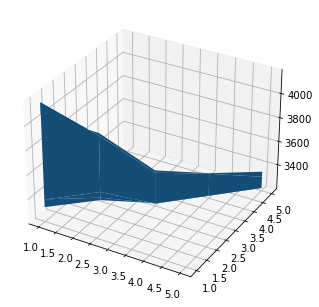

In [75]:
fig = plt.figure()
ax = Axes3D(fig)
x = range(1,6)
surf = ax.plot_surface(x, x, AIC)

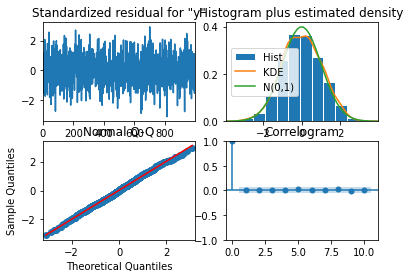

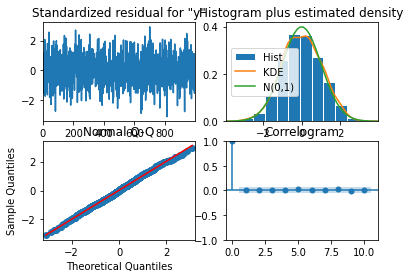

In [51]:
res_arma3.plot_diagnostics()